### note
1. theres high chance that those models are overfitting.
2. issues 
    - class imbalanced
    - dataset is small
    - 'missing cabin' column (high collinearity)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
df = pd.read_csv('titanic.csv')
df = df.drop(columns=['PassengerId','Name','Ticket'])

from sklearn.preprocessing import OneHotEncoder

def ohe_sex(df,col):
    
    ohe_sex = OneHotEncoder(drop='first')
    result = ohe_sex.fit_transform(df[[col]]).toarray()
    
    return result

def ohe_embarked(df,col):
    
    ohe_embarked = OneHotEncoder(drop='first')
    result = ohe_embarked.fit_transform(df[[col]]).toarray()
    result = pd.DataFrame(result, columns=df[col].unique()[0:2])
    df = pd.concat([df, result], axis=1)
    df.drop(columns=['Embarked'],inplace=True)

    return df

# Transform the 'Sex' column using the OneHotEncoder

 # 1 = male, 0 = female
df['Sex'] = ohe_sex(df,'Sex')

# [Q,S] => [0,0] => C
df = ohe_embarked(df,'Embarked')

df['Cabin'] = df[~df['Cabin'].isnull()]['Cabin'].str[0]

df['Cabin'] = df['Cabin'].fillna('Missing')

cabin_mapping = {'Missing':0,
                 'A': 1, 'B': 2, 'C': 3,
                 'D': 4, 'E': 5, 'F': 6, 
                 'G': 7}

df['Cabin'] = df['Cabin'].map(cabin_mapping)
#df['Miss_cabin'] = np.where(df['Cabin']==0, 1,0)

df[df['Fare'] == 0] # reasonable, maybe that guy is vip
# 1 row of Fare is NaN
df[df['Fare'].isnull()].index # remove this row or impute with median
df = df.drop(index = df[df['Fare'].isnull()].index)

df[df['Age'].isnull()].shape # for age, many rows is NaN, hence impute with mean is better
df['Age'] = df['Age'].fillna(df['Age'].mean())

X = df.drop(columns=['Survived'])
y = df['Survived']

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,random_state=43,test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)



(333, 9)
(84, 9)
(333,)
(84,)


Original Distribution:


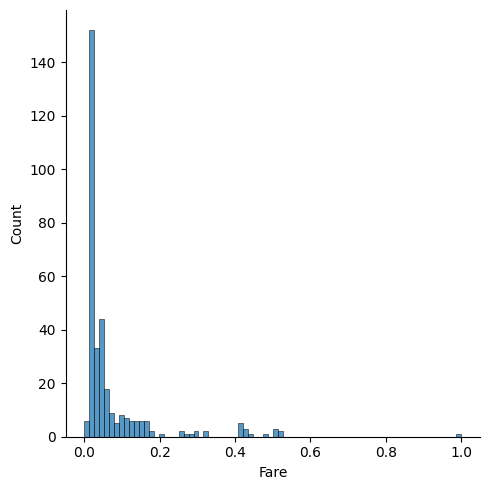

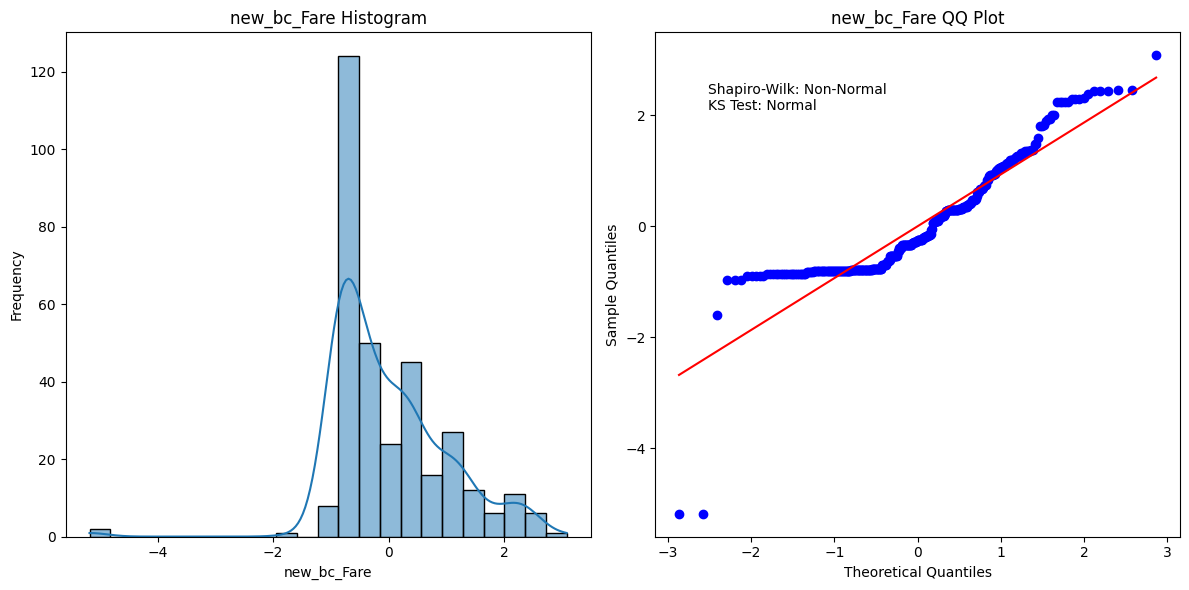

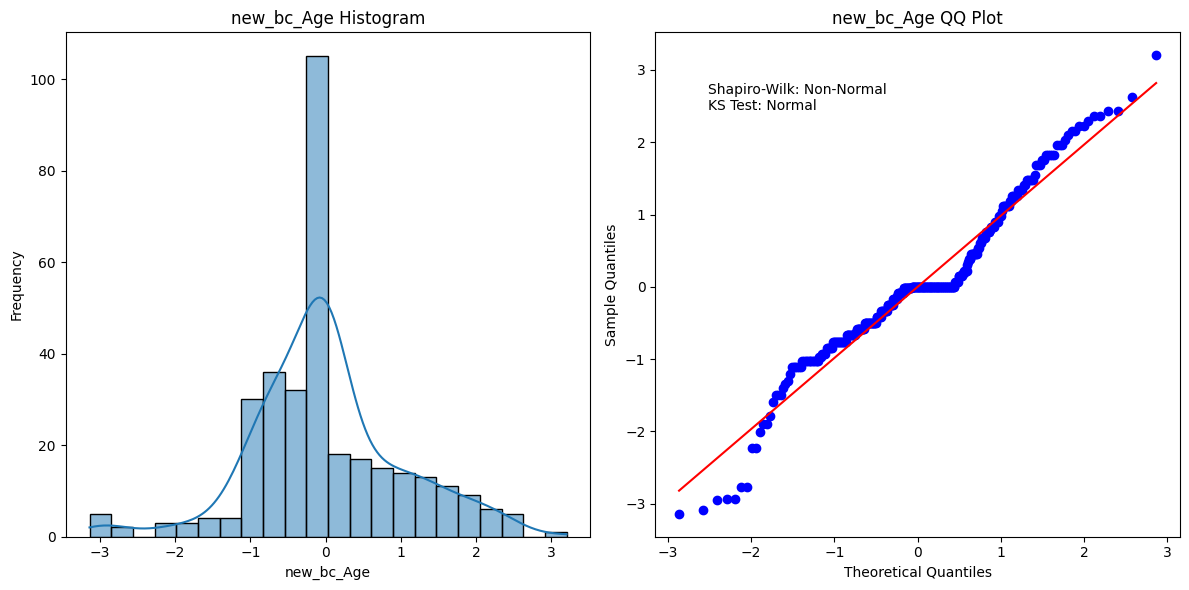

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler_Age = MinMaxScaler()
scaler_Fare = MinMaxScaler()

def Standard_Age(X,col):
    X[col] = scaler_Age.fit_transform(X[[col]])
    return X[col]

def Standard_Fare(X,col):
    
    X[col] = scaler_Fare.fit_transform(X[[col]])
    return X[col]

X_train['Age'] = Standard_Age(X_train,'Age')
X_train['Fare'] = Standard_Fare(X_train,'Fare')

X_train.head()

# right skew distribution - perform data transformation
import scipy.stats as stat
import pylab
from sklearn.preprocessing import PowerTransformer
from qqplot import plot_data
print('Original Distribution:')
sns.displot(X_train['Fare'])
plt.show()

def transformer(df,col,method):
    if method == 'box-cox':
        bc = PowerTransformer(method=method)
        bc_data = bc.fit_transform(df[[col]]+0.0001)
        df[f'new_bc_{col}'] = bc_data

        return bc
    
    yj = PowerTransformer(method=method)
    yj_data = yj.fit_transform(df[[col]])
    df[f'new_yj_{col}'] = yj_data

    return yj

bc_fare = transformer(X_train,'Fare','box-cox')
bc_age = transformer(X_train,'Age','box-cox')

plot_data(X_train,'new_bc_Fare')
plot_data(X_train,'new_bc_Age')

In [5]:
# For Age & Fare => Box-cox is selected 
X_train = X_train[['Pclass','Sex','SibSp','Parch','Cabin','Q','S','new_bc_Fare','new_bc_Age']]
X_train.head()

,Pclass,Sex,SibSp,Parch,Cabin,Q,S,new_bc_Fare,new_bc_Age
257,3,1.0,0,0,0,0.0,1.0,-0.769710,-0.171383
1,3,0.0,1,0,0,0.0,1.0,-0.894863,1.263416
341,3,1.0,0,0,0,0.0,1.0,-0.823719,0.146601
160,3,0.0,0,0,0,1.0,0.0,-0.805688,0.003301
172,3,1.0,1,0,0,0.0,1.0,-0.277307,-0.585077


set()


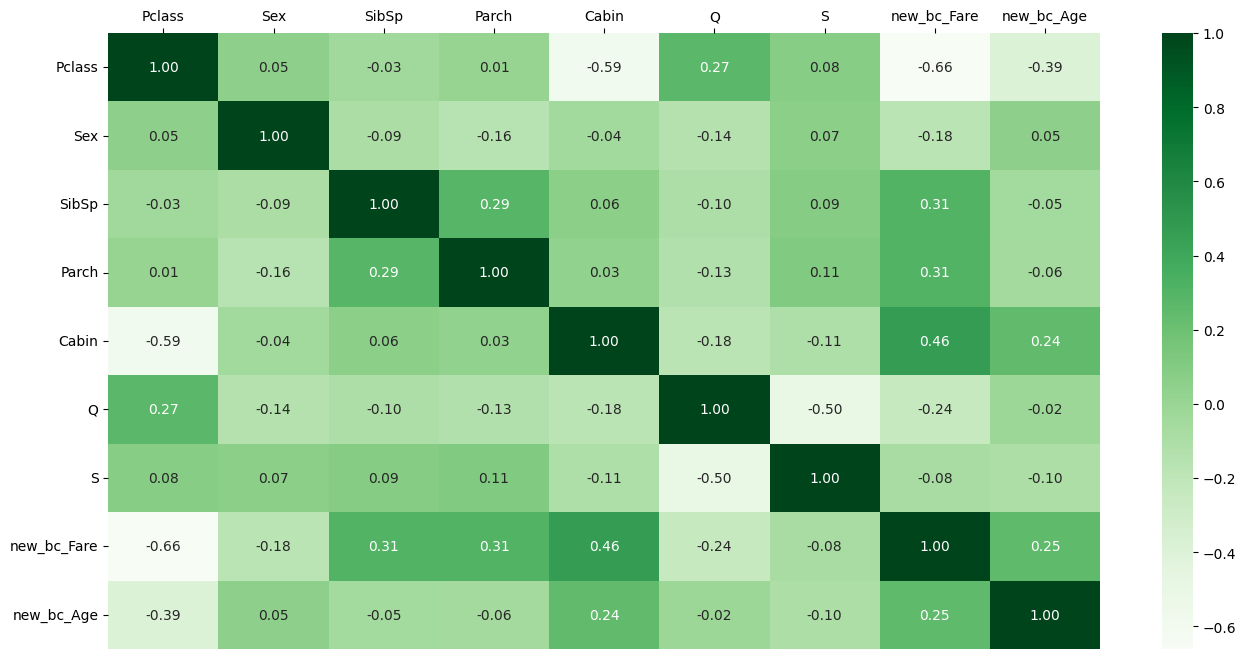

In [6]:
def check_corr(df,threshold):
    corr_mat = df.corr()
    redundant = np.where(np.abs(corr_mat)>=threshold)
    
    correlated_features=set()
    for i,j in zip(*redundant):
        if i!=j and i<j:
            #print(X.columns[i],X.columns[j])
            correlated_features.add((df.columns[i],df.columns[j]))

    return correlated_features

result = check_corr(X_train,0.7)
print(result)


plt.figure(figsize=(16, 8))
ax = sns.heatmap(X_train.corr(),annot=True,fmt='.2f',cmap='Greens',)
ax.xaxis.tick_top()
plt.show()

In [7]:
def test_preprocess():
    X_test['Age'] = scaler_Age.transform(X_test[['Age']])
    X_test['Fare'] = scaler_Fare.transform(X_test[['Fare']])
    
    X_test['new_bc_Age'] = bc_age.transform(X_test[['Age']])
    X_test['new_bc_Fare'] = bc_fare.transform(X_test[['Fare']])

    data = X_test[['Pclass','Sex','SibSp','Parch','Cabin','Q','S','new_bc_Fare','new_bc_Age']]

    return data

X_test = test_preprocess()

X_test.head()

,Pclass,Sex,SibSp,Parch,Cabin,Q,S,new_bc_Fare,new_bc_Age
144,1,1.0,0,0,0,0.0,1.0,0.310449,0.901866
375,1,0.0,0,0,0,0.0,0.0,2.446219,1.119654
364,1,0.0,1,0,5,0.0,0.0,0.989512,-0.417826
290,1,1.0,0,0,0,0.0,1.0,0.678303,0.002699
88,3,0.0,0,0,0,1.0,0.0,-0.809698,0.002699


In [8]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(333, 9) (333,)
(84, 9) (84,)


In [9]:
y_train.value_counts()

Survived
0    212
1    121
Name: count, dtype: int64

In [10]:
## Class Imbalanced:
## two common approach (over,under)
from Dataresampling import Oversampler,Undersampler

# - undersampling

usamp = Undersampler(X_train,y_train)
X_Ures,y_Ures = usamp.CC()

# - oversampling
osamp = Oversampler(X_train,y_train)
X_Ores,y_Ores = osamp.ADASYN()



US Method: [TL,CC]
ClusterCentroid
After: Counter({0: 121, 1: 121}) 

OS Method: [ADASYN]
ADASYN
After: Counter({1: 219, 0: 212}) 



### Fine Tuning Part
### Classifier Selected:
- svm 
- rf
- lr
- nn


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

class Grid:
    X,y=None,None

    def __init__(self,X,y):
        self.X=X
        self.y=y
        print(self.X.shape,self.y.shape)
    
    #SVM
    def SVM_grid(self):
        SVM_clf = SVC(random_state=43)

        param_grid = {
            'C' : [1.0,0.1,0.01,0.001],
            'kernel' : ['linear','rbf'],
            'degree' : [2,3,4,5,6],
        }

        SVM_grid = GridSearchCV(estimator=SVM_clf,param_grid=param_grid,
                                scoring='accuracy',cv=10,
                                n_jobs=-1,verbose=3).fit(self.X,self.y)
        print('_SVM_')
        print(SVM_grid.best_params_)
        print(SVM_grid.best_score_,'\n')

    #randomforest
    def RF_grid(self):
        RF_clf = RandomForestClassifier(random_state=43)

        param_grid = {
            'n_estimators': [50,100,200,250,350,400],
            'criterion': ['gini','entropy','log_loss'],
            'max_depth': [5,10,20,50,100,None],
            'min_samples_split': [2,3,4],
            'min_samples_leaf': [1,2],
            'max_features': ['sqrt','log2',None]

        }

        RF_grid = GridSearchCV(estimator=RF_clf,param_grid=param_grid,
                                scoring='accuracy',cv=10,
                                n_jobs=-1,verbose=3).fit(self.X,self.y)
        print('_RF_')
        print(RF_grid.best_params_)
        print(RF_grid.best_score_,'\n')

    #logisticregression
    def LR_grid(self):
        LR_clf = LogisticRegression(random_state=43)

        param_grid = {
            'C':[1.0,0.1,0.01,0.001],
            'solver':['lbfgs','liblinear','newton-cg','newton-cholesky','sag','saga'],
            'max_iter':[100,150,200,250,300]
        }

        LR_grid = GridSearchCV(estimator=LR_clf,param_grid=param_grid,
                                scoring='accuracy',cv=10,
                                n_jobs=-1,verbose=3).fit(self.X,self.y)
        print('_LR_')
        print(LR_grid.best_params_)
        print(LR_grid.best_score_,'\n')  

Grid_U = Grid(X_Ures,y_Ures)
Grid_O = Grid(X_Ores,y_Ores)

(242, 9) (242,)
(431, 9) (431,)


In [12]:
import keras_tuner as kt
from keras import Sequential,Input
from keras.layers import Dense,Dropout
from sklearn.model_selection import train_test_split

class nn_tuner:
    X=None
    y=None
    input_shape = None

    X_train,y_train=None,None
    X_valid,y_valid=None,None

    def __init__(self,X,y):
        self.X=X
        self.y=y
        print(self.X.shape,self.y.shape)
        print('Data Load Finish.')
        self.input_shape = (self.X.shape[1],)
    
        self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(self.X, self.y,
                                                  test_size = 0.2,
                                                  stratify = self.y,
                                                  random_state = 43
                                                 )

    #neuralnetwork
    def Neural(self):
        def build_model(hp):
            model = Sequential()
            model.add(Input(shape=self.input_shape))

            # Define number of hidden layers
            num_hidden_layers = hp.Int('number_hidden_layers',
                                       min_value=2,max_value=10,
                                       default=4)
            for i in range(num_hidden_layers):
                #Define number of neurons for ea layer
                num_neurons = hp.Int(f'units_{i}',
                                     min_value=8,max_value=256,default=32)
                dropout_rate = hp.Float(f'dropout_{i}',
                                        min_value=0.0,max_value=0.5,default=0.2)
                model.add(Dense(units=num_neurons,activation='relu'))
                # Decide whether to add a dropout anot
                if hp.Boolean("dropout"):
                    model.add(Dropout(rate=dropout_rate))

            model.add(Dense(units=1,activation='sigmoid'))

            # Optimizer
            opt_choice = hp.Choice('optimizer',['sgd','rmsprop','adam','adagrad'])
            
            # Compile model
            model.compile(optimizer = opt_choice,
                          loss = 'binary_crossentropy',
                          metrics = ['accuracy']
                          )

            return model
        
        tuner = kt.GridSearch(
            hypermodel = build_model,
            objective = 'val_loss',
            overwrite = True,
            max_trials = 100
        )
        
        tuner.search(self.X_train,self.y_train,
                     epochs=10,validation_data=(self.X_valid,self.y_valid))

        best_hp = tuner.get_best_hyperparameters()[0]
        tuned_model = tuner.hypermodel.build(best_hp)
        
        return tuned_model
    
NN_U = nn_tuner(X_Ures,y_Ures)
NN_O = nn_tuner(X_Ores,y_Ores)


(242, 9) (242,)
Data Load Finish.
(431, 9) (431,)
Data Load Finish.


In [62]:
NN_grid = NN_U.Neural()

Trial 100 Complete [00h 00m 02s]
val_loss: 0.6862317323684692

Best val_loss So Far: 0.306684285402298
Total elapsed time: 00h 03m 24s


In [63]:
NN_grid.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 32)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
#Grid_U
Grid_U.SVM_grid()
Grid_U.RF_grid()
Grid_U.LR_grid()


Fitting 10 folds for each of 40 candidates, totalling 400 fits


_SVM_
{'C': 1.0, 'degree': 2, 'kernel': 'linear'}
1.0 

Fitting 10 folds for each of 1944 candidates, totalling 19440 fits
_RF_
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
1.0 

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
_LR_
{'C': 1.0, 'max_iter': 100, 'solver': 'lbfgs'}
1.0 



In [67]:
# Retrain those model witht their opt hp

#for SVM - {'C': 1.0, 'degree': 2, 'kernel': 'linear'}
SVM_tuned = SVC(C=1.0,degree=2,kernel='linear').fit(X_Ures,y_Ures)
y_pred_SVM_U = SVM_tuned.predict(X_test)

#for RF - {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RF_tuned = RandomForestClassifier(criterion='gini',max_depth=5,max_features='sqrt',min_samples_leaf=1,min_samples_split=2,n_estimators=50).fit(X_Ures,y_Ures)
y_pred_RF_U = RF_tuned.predict(X_test)

#for LR - {'C': 1.0, 'max_iter': 100, 'solver': 'lbfgs'}
LR_tuned = LogisticRegression(C=1.0,max_iter=100,solver='lbfgs').fit(X_Ures,y_Ures)
y_pred_LR_U = LR_tuned.predict(X_test)

from keras.callbacks import EarlyStopping

callbacks = EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=10,
    mode="auto",
    restore_best_weights=True,
)

history_U = NN_grid.fit(NN_U.X_train,NN_U.y_train,
                      epochs=100,validation_data=(NN_U.X_valid,NN_U.y_valid),
                      callbacks=callbacks)
y_pred_NN_U = NN_grid.predict(X_test)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0021

In [17]:
#Grid_O
Grid_O.SVM_grid()
Grid_O.RF_grid()
Grid_O.LR_grid()

Fitting 10 folds for each of 40 candidates, totalling 400 fits
_SVM_
{'C': 1.0, 'degree': 2, 'kernel': 'linear'}
1.0 

Fitting 10 folds for each of 1944 candidates, totalling 19440 fits
_RF_
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
1.0 

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
_LR_
{'C': 1.0, 'max_iter': 100, 'solver': 'lbfgs'}
1.0 



In [18]:
#NN_O
NN_grid_O = NN_O.Neural()
NN_grid_O.summary()

Trial 100 Complete [00h 00m 02s]
val_loss: 0.6468439102172852

Best val_loss So Far: 0.0163927860558033
Total elapsed time: 00h 03m 38s


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 32)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
# Retrain those model witht their opt hp

#for SVM - {'C': 1.0, 'degree': 2, 'kernel': 'linear'}
SVM_tuned = SVC(C=1.0,degree=2,kernel='linear').fit(X_Ores,y_Ores)
y_pred_SVM_O = SVM_tuned.predict(X_test)

#for RF - {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RF_tuned = RandomForestClassifier(criterion='gini',max_depth=5,max_features='sqrt',min_samples_leaf=1,min_samples_split=2,n_estimators=50).fit(X_Ores,y_Ores)
y_pred_RF_O = RF_tuned.predict(X_test)

#for LR - {'C': 1.0, 'max_iter': 100, 'solver': 'lbfgs'}
LR_tuned = LogisticRegression(C=1.0,max_iter=100,solver='lbfgs').fit(X_Ores,y_Ores)
y_pred_LR_O = LR_tuned.predict(X_test)

from keras.callbacks import EarlyStopping

callbacks = EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=10,
    mode="auto",
    restore_best_weights=True,
)

history_O = NN_grid_O.fit(NN_O.X_train,NN_O.y_train,
                      epochs=100,validation_data=(NN_O.X_valid,NN_O.y_valid),
                      callbacks=callbacks)
y_pred_NN_O = NN_grid_O.predict(X_test)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4981 - loss: 0.6996 - val_accuracy: 0.7011 - val_loss: 0.6646
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6685 - loss: 0.6668 - val_accuracy: 0.7701 - val_loss: 0.6292
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7159 - loss: 0.6334 - val_accuracy: 0.8046 - val_loss: 0.5728
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7703 - loss: 0.5778 - val_accuracy: 0.8621 - val_loss: 0.4951
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8499 - loss: 0.4938 - val_accuracy: 0.9885 - val_loss: 0.3986
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9543 - loss: 0.3972 - val_accuracy: 1.0000 - val_loss: 0.2780
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9853 - loss: 0.2559 - val_accuracy: 1.0000 - val_loss: 0.1553
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9911 - loss: 0.1378 - val_accuracy: 1.0000 - 

In [71]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

def result(y1,y2):
    acc = accuracy_score(y1,y2)
    cm = confusion_matrix(y1,y2)
    cr = classification_report(y1,y2)

    print(f'Accuracy score : {acc:.2f}\n')
    print(cm)
    print(cr)    

    return acc

print('UnderSampling Results:')
SVC_score_U = result(y_test,y_pred_SVM_U)
RF_score_U = result(y_test,y_pred_RF_U)
LR_score_U = result(y_test,y_pred_LR_U)

result_NN_U = np.where(y_pred_NN_U>0.5,1,0)
NN_score_U = result(y_test,result_NN_U)

print('OverSampling Results:')
SVC_score_O = result(y_test,y_pred_SVM_O)
RF_score_O = result(y_test,y_pred_RF_O)
LR_score_O = result(y_test,y_pred_LR_O)

result_NN_O = np.where(y_pred_NN_O>0.5,1,0)
NN_score_O = result(y_test,result_NN_O)

UnderSampling Results:
Accuracy score : 1.00

[[53  0]
 [ 0 31]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        31

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84

Accuracy score : 1.00

[[53  0]
 [ 0 31]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        31

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84

Accuracy score : 1.00

[[53  0]
 [ 0 31]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        31

    accuracy                     

In [66]:
print(y_pred_NN_U)

[[5.5687735e-03]
 [9.9530447e-01]
 [9.5351249e-01]
 [4.9364017e-03]
 [9.9983513e-01]
 [2.3053081e-03]
 [9.2588246e-01]
 [1.3205211e-03]
 [7.0540659e-04]
 [9.9982858e-01]
 [9.9422044e-01]
 [9.9982625e-01]
 [8.1116339e-04]
 [1.2560006e-03]
 [9.9975991e-01]
 [1.3954811e-02]
 [2.1165120e-03]
 [1.3524869e-03]
 [2.3086919e-03]
 [7.6965307e-04]
 [9.9975711e-01]
 [9.9866980e-01]
 [4.3147248e-03]
 [1.5536731e-03]
 [2.3244382e-03]
 [8.8185898e-04]
 [5.8197537e-03]
 [3.1155800e-03]
 [1.1659574e-03]
 [2.1378254e-03]
 [1.4595408e-03]
 [9.7698498e-01]
 [1.1718514e-03]
 [5.0175400e-03]
 [9.8554248e-01]
 [1.1156735e-03]
 [1.1988974e-03]
 [1.9764728e-03]
 [9.9863827e-01]
 [9.9914879e-01]
 [1.1276985e-03]
 [9.9834955e-01]
 [9.9949151e-01]
 [9.4705844e-01]
 [9.9710435e-01]
 [1.5507435e-03]
 [1.8984312e-03]
 [5.4194726e-04]
 [1.3630755e-03]
 [1.3534849e-03]
 [9.9951184e-01]
 [7.0261827e-04]
 [9.9631298e-01]
 [1.1659574e-03]
 [1.2499993e-03]
 [1.1754452e-03]
 [9.9891740e-01]
 [9.7482228e-01]
 [1.0274813e-0

In [73]:
# to be continue, graph plotting
score_US = [SVC_score_U,RF_score_U,LR_score_U,NN_score_U]
score_OS = [SVC_score_O,RF_score_O,LR_score_O,NN_score_O]
clf = ['SVM','RF','LR','NN']

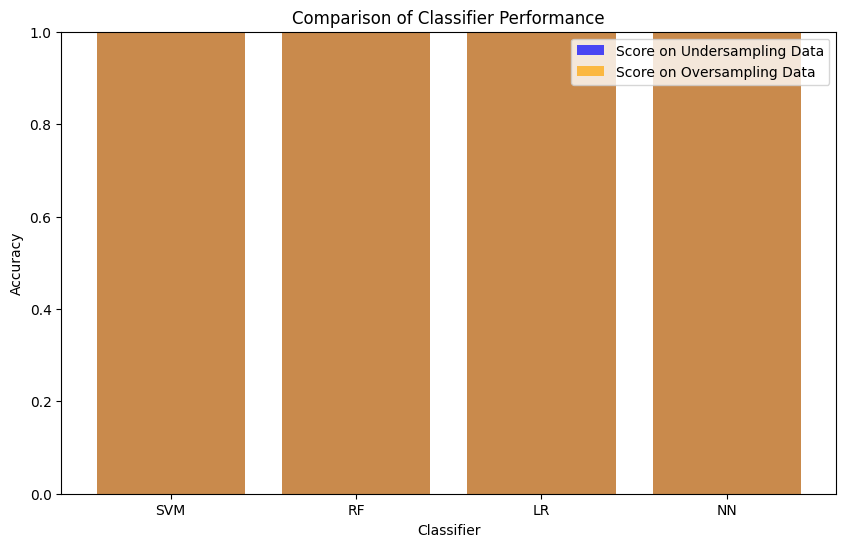

In [78]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(clf, score_US, color='blue', alpha=0.7, label='Score on Undersampling Data')
plt.bar(clf, score_OS, color='orange', alpha=0.7, label='Score on Oversampling Data')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Comparison of Classifier Performance')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for accuracy values
plt.show()



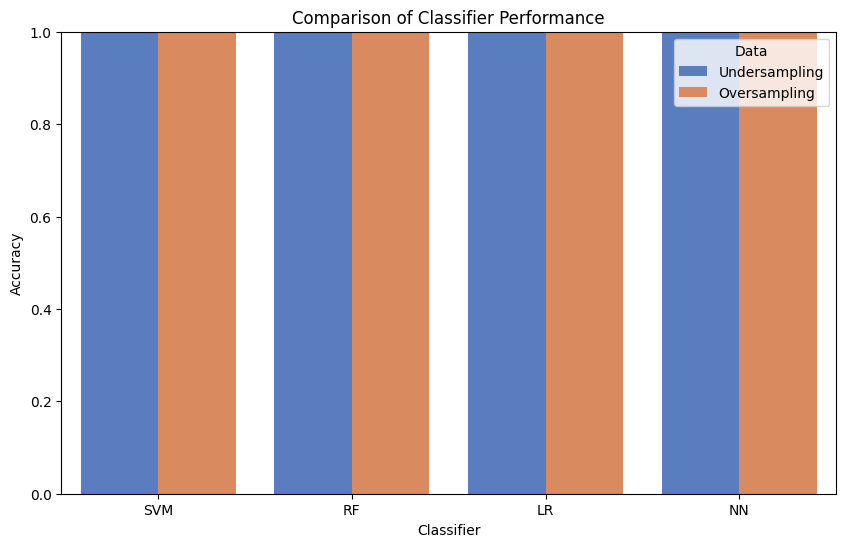

In [80]:
df_output = pd.DataFrame({
    'Classifier': clf * 2,
    'Score': score_US + score_OS,
    'Data': ['Undersampling'] * len(clf) + ['Oversampling'] * len(clf)
})

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=df_output, x='Classifier', y='Score', hue='Data', palette='muted')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Comparison of Classifier Performance')
plt.legend(title='Data')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for accuracy values
plt.show()

### Thoughts : 
- The dataset is too small, hence os/us doesnt affect the result much.
- Also there is too many missing values on the cabin features, where it actually having high effect on the passenger's survival rate.
- But in short, the model performed well after tuning.
